<img src="https://www.th-koeln.de/img/logo.svg" style="float:right;" width="200">

# 9th exercise: <font color="#C70039">Interpretable Machine Learning by means of Partial Dependence (PDP) and Individual Conditional Expectation (ICE) Plots</font>
* Course: AML
* Lecturer: <a href="https://www.gernotheisenberg.de/">Gernot Heisenberg</a>
* Author of notebook: <a href="https://www.gernotheisenberg.de/">Gernot Heisenberg</a>
* Date:     20.12.2025
* Student: Tim Voßmerbäumer
* Matr.Nr.: 11474232

<img src="https://scikit-learn.org/stable/_images/sphx_glr_plot_partial_dependence_003.png" style="float: center;" width="800">

---------------------------------
**GENERAL NOTE 1**:
Please make sure you are reading the entire notebook, since it contains a lot of information on your tasks (e.g. regarding the set of certain paramaters or a specific computational trick), and the written mark downs as well as comments contain a lot of information on how things work together as a whole.

**GENERAL NOTE 2**:
* Please, when commenting source code, just use English language only.
* When describing an observation please use English language, too.
* This applies to all exercises throughout this course.

---------------------------------

### <font color="ce33ff">DESCRIPTION</font>:

Partial dependence plots (PDP) and individual conditional expectation (ICE) plots can be used to visualize and analyze the interaction between the target response and a set of input features of interest.
Both PDPs [H2009] and ICEs [G2015] assume that the input features of interest are independent from the complement features and this assumption is often violated in practice. Thus, in the case of correlated features, we will create absurd data points to compute the PDP/ICE.

[H2009]
T. Hastie, R. Tibshirani and J. Friedman, The Elements of Statistical Learning, Second Edition, Section 10.13.2, Springer, 2009.

[G2015]
A. Goldstein, A. Kapelner, J. Bleich, and E. Pitkin, “Peeking Inside the Black Box: Visualizing Statistical Learning With Plots of Individual Conditional Expectation” Journal of Computational and Graphical Statistics, 24(1): 44-65, Springer, 2015.

---------------------------------

### <font color="FFC300">TASKS</font>:
The tasks that you need to work on within this notebook are always indicated below as bullet points.
If a task is more challenging and consists of several steps, this is indicated as well.
Make sure you have worked down the task list and commented your doings.
This should be done by using markdown.<br>
<font color=red>Make sure you don't forget to specify your name and your matriculation number in the notebook.</font>

**YOUR TASKS in this exercise are as follows**:
1. import the notebook to Google Colab or use your local machine.
2. make sure you specified you name and your matriculation number in the header below my name and date.
    * set the date too and remove mine.
3. read the entire notebook carefully
    * add comments whereever you feel it necessary for better understanding
    * run the notebook for the first time.
    * try to follow the interpretations by printing out the decision tree and look for the feature patterns that the PDPs indicate.

**PART I**<br>
4. download an interesting data set from Kaggle and do the preprocessing.<br>
5. change the classifier according to the data set. The more blackbox the better.<br>
6. use PDP to identify the most relevant features explaining the target response of the data set.<br>
7. comment your entire code and your findings.<br>  

**PART II**<br>
8. use the data set and the classifer from steps 4 and 5<br>
9. plot ICE curves with parameter (kind='both')<br>
10. comment your entire code and your findings.<br>  

---------------------------------

# <font color="ce33ff">PART I (Partial Dependence Plots)</font>

## Imports
Import all necessary python utilities.

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor # Changed from RandomForestClassifier

from matplotlib import pyplot as plt
from sklearn.inspection import PartialDependenceDisplay

## Load data set

In [2]:
data = pd.read_csv('./data/cali_housing/housing.csv')
data.head(10)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
5,-122.25,37.85,52.0,919.0,213.0,413.0,193.0,4.0368,269700.0,NEAR BAY
6,-122.25,37.84,52.0,2535.0,489.0,1094.0,514.0,3.6591,299200.0,NEAR BAY
7,-122.25,37.84,52.0,3104.0,687.0,1157.0,647.0,3.1200,241400.0,NEAR BAY
8,-122.26,37.84,42.0,2555.0,665.0,1206.0,595.0,2.0804,226700.0,NEAR BAY
9,-122.25,37.84,52.0,3549.0,707.0,1551.0,714.0,3.6912,261100.0,NEAR BAY


In [3]:
# all features are:
print(data.columns.tolist())

['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value', 'ocean_proximity']


## Preprocessing


In [4]:
# Check for missing values in all columns
print("Missing values before preprocessing:")
print(data.isnull().sum())


Missing values before preprocessing:
longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64


In [5]:
# Handle missing values by filling with the median
data['total_bedrooms'].fillna(data['total_bedrooms'].median(), inplace=True)

# Convert categorical feature 'ocean_proximity' to numerical using one-hot encoding
data = pd.get_dummies(data, columns=['ocean_proximity'], drop_first=True)

# Define target variable (y) and features (X)
y = data['median_house_value']
x = data.drop('median_house_value', axis=1)

# Ensure all feature names are strings for compatibility with some models
x.columns = x.columns.astype(str)

C:\Users\tvossmerbaeumer_scal\AppData\Local\Temp\ipykernel_10212\431041134.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['total_bedrooms'].fillna(data['total_bedrooms'].median(), inplace=True)


In [6]:
# Check for missing values in all columns after filling
print("Missing values before preprocessing:")
print(data.isnull().sum())


Missing values before preprocessing:
longitude                     0
latitude                      0
housing_median_age            0
total_rooms                   0
total_bedrooms                0
population                    0
households                    0
median_income                 0
median_house_value            0
ocean_proximity_INLAND        0
ocean_proximity_ISLAND        0
ocean_proximity_NEAR BAY      0
ocean_proximity_NEAR OCEAN    0
dtype: int64


## Train the classifier

Start with a simple decision tree model.
<font color=red>Note:</font> The calculation of a partial dependence can happen obviously, only after a model has been trained.

In [7]:
train_x, val_x, train_y, val_y = train_test_split(x, y, random_state=1)
# Change from DecisionTreeClasifier to Regressor because the median_house_value is a continuous feature
tree_model = DecisionTreeRegressor(random_state=0, max_depth=5, min_samples_split=5).fit(train_x, train_y)

## Partial Dependence Plots (PDP)
#### read the API reference guide for further possibilities

Housing prices are often dependant on the median_income of the are

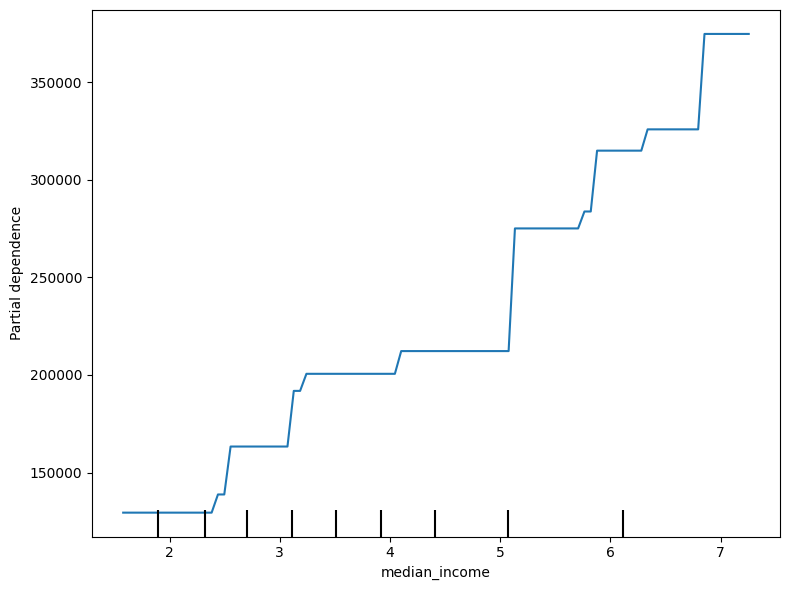

In [8]:
feature_name = 'median_income'

# draw the Partial Dependence Plot
fig, ax = plt.subplots(figsize=(8, 6))
PartialDependenceDisplay.from_estimator(
    estimator=tree_model,
    X=val_x,
    features=[feature_name],
    kind="average",  # alternative: "individual" for ICE-Plots
    ax=ax
)
plt.tight_layout()
plt.show()

The plot clearly shows a positive relationship between median_income and median_house_value.

I figured that population is also often an indicator for house prices.

c:\Users\tvossmerbaeumer_scal\Documents\Uni-work\AML\.venv\Lib\site-packages\sklearn\inspection\_plot\partial_dependence.py:990: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim([min_val, max_val])


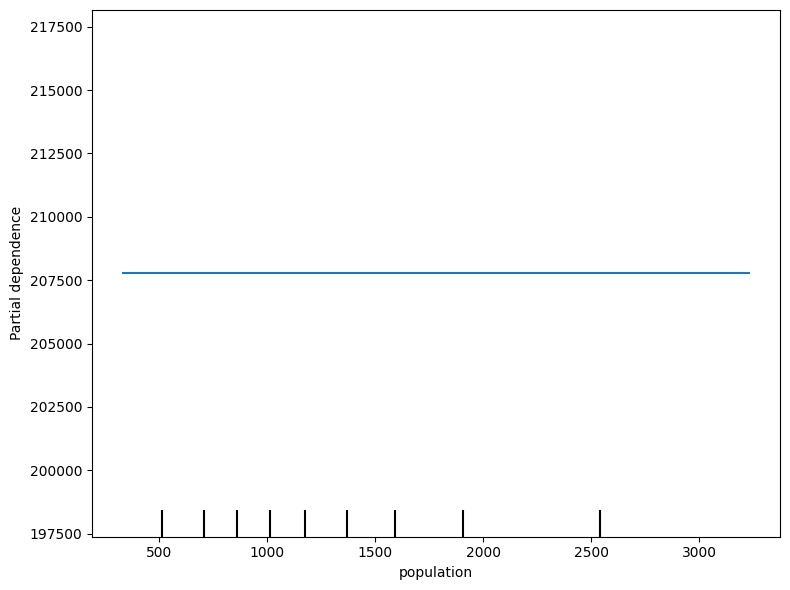

In [9]:
feature_name = 'population'

# draw the Partial Dependence Plot
fig, ax = plt.subplots(figsize=(8, 6))
PartialDependenceDisplay.from_estimator(
    estimator=tree_model,
    X=val_x,
    features=[feature_name],
    kind="average",  # alternative: "individual" for ICE-Plots
    ax=ax
)
plt.tight_layout()
plt.show()

But according to the PDP, there is no correlation between population and median_housing_value

## Random Forest Regressor (Continuous feature)

In [10]:
# Build a new model: Random Forest Regressor
rf_model = RandomForestRegressor(random_state=0, n_estimators=50, max_depth=10).fit(train_x, train_y)

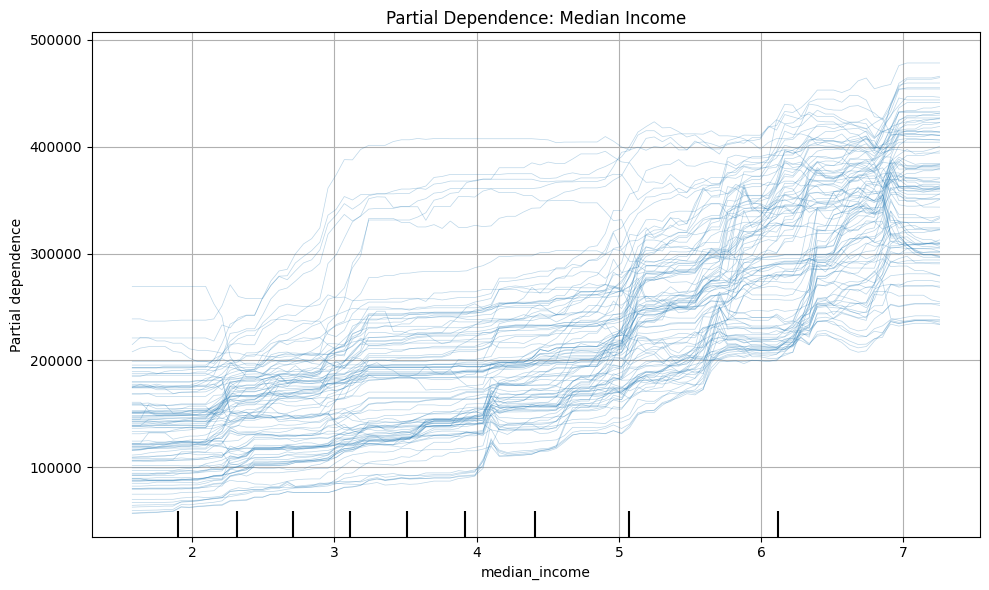

In [11]:
feature = 'median_income'

# PDP with ICE lines
fig, ax = plt.subplots(figsize=(10, 6))
PartialDependenceDisplay.from_estimator(
    estimator=rf_model,
    X=val_x,
    features=[feature],
    kind='individual',        # ICE
    grid_resolution=100,      # number of points on x-axis
    subsample=100,            # number of ICE lines
    ax=ax
)

plt.title("Partial Dependence: Median Income")
plt.grid(True)
plt.tight_layout()
plt.show()

<font color=red>Interpretation:</font>
The Partial Dependence Plot for 'median_income' suggests a strong positive correlation between median income and median house value. As the median income increases, the predicted median house value also tends to increase. The ICE lines indicate that this trend is consistent across different instances in the dataset, with a generally upward slope. This implies that higher-income areas are associated with higher housing prices in the California housing dataset.


## 2D Partial Depedence Plot

Now, plotting the PDP for two features can be done by using the **pdp_interact** and **pdp_interact_plot** functions.

First, switch back to the simple decision tree model.

In [12]:
train_x, val_x, train_y, val_y = train_test_split(x, y, random_state=1)
tree_model = DecisionTreeRegressor(random_state=0, max_depth=5, min_samples_split=5).fit(train_x, train_y)

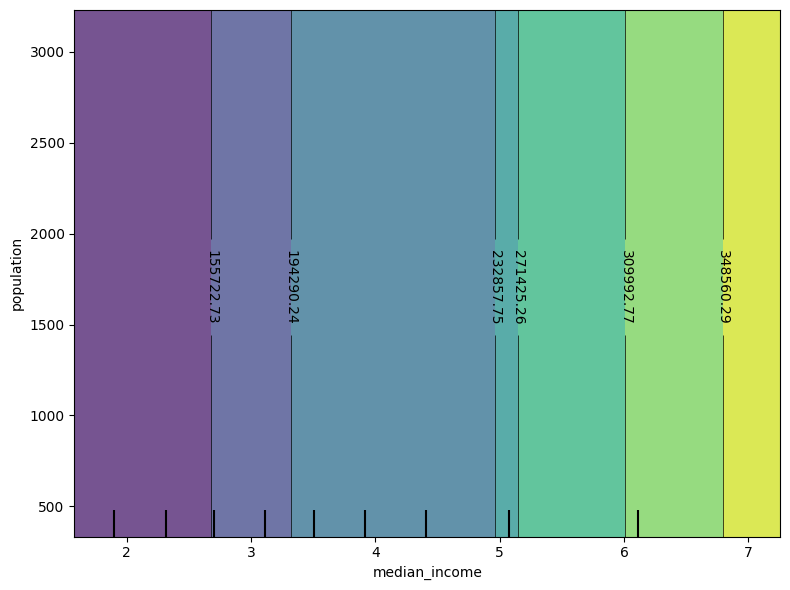

In [13]:
# Similar to previous PDP plot

# Define the pair of features to visualize their interaction
features_to_plot = [('median_income', 'population')]

# Create the Partial Dependence Plot (PDP) for the interaction
fig, ax = plt.subplots(figsize=(8, 6))
PartialDependenceDisplay.from_estimator(
    estimator=tree_model,
    X=val_x,
    features=features_to_plot,
    kind='average',           # Interaction PDPs only support 'average'
    grid_resolution=20,       # Controls the granularity of the plot
    ax=ax
)

# Show the plot
plt.tight_layout()
plt.show()

<font color=red>Interpretation:</font>
This **2D PDP** visualizes the combined effect of **Median Income** and **Population** on the predicted median house value.
It appears that higher median incomes generally lead to higher predicted house values, as observed in the 1D PDP. The interaction with population is more nuanced: for a given median income, there might be an optimal population range that maximizes house values. Very low or very high populations could potentially lead to slightly lower predictions compared to moderately populated areas, especially within certain income brackets. This suggests that both factors together influence housing prices in a complex, non-linear manner.

# <font color="ce33ff">PART II (Individual Conditional Expectation)</font>

ICE is also a model-agnostic method that can be applied to any model.
In fact, it is basically the same concept as PDP but is different in that it displays the marginal effect of feature(s)
for each instance instead of calculating the average effect in a overall data context as the PDP does.
Thus, it can understood as the equivalent to a PDP for individual data instances.
Visually, an ICE plot displays the dependence of the prediction on a feature for each instance separately,
resulting in one line per instance.

There are multiple packages and libraries that can be used to compute ICE plots.

The PartialDependenceDisplay function in the sklearn.inspection module, the PyCEBox package and H2O package’s ice_plot function are available.

Let’s take a look at an example in Sklearn’s documentation (https://scikit-learn.org/stable/modules/partial_dependence.html).

## Imports
Import all necessary python utilities.

In [14]:
import numpy as np
import pandas as pd

from sklearn.datasets import make_hastie_10_2
from sklearn.ensemble import GradientBoostingClassifier

# make sure you have installed scikit-learn of version > 1.0
# since the method from_estimator() is not available in previous versions
from sklearn.inspection import PartialDependenceDisplay

## Partial Dependence Plots (PDP)
read the API reference guide for further possibilities
Read some inbuild data set as part of the Sklearn data sets being offered
To get more information on the data set please refer to


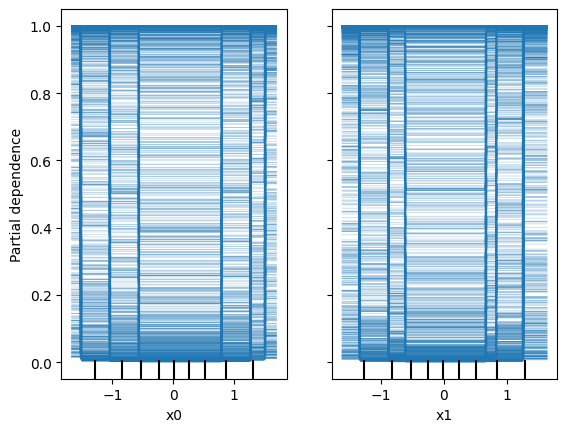

In [ ]:
''' https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_hastie_10_2.html '''

x, y = make_hastie_10_2(random_state=42) # set a seed with random_state

clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0).fit(x, y)
features = [0, 1] #features x and y

PartialDependenceDisplay.from_estimator(clf, x, features, kind='individual')

<font color=red>Interpretation of Individual Conditional Expectation (ICE) Plot (make_hastie_10_2 dataset):</font>
This ICE plot visualizes the effect of features 0 and 1 from the `make_hastie_10_2` dataset on the predicted outcome, for individual instances. Each line represents a single instance's prediction as one of the features changes. The plot shows how the model's prediction for each instance varies with changes in the specified feature, while other features are held constant at their original values for that instance. This helps in understanding individual sample behavior and detecting heterogeneous effects that might be hidden in an aggregated PDP.

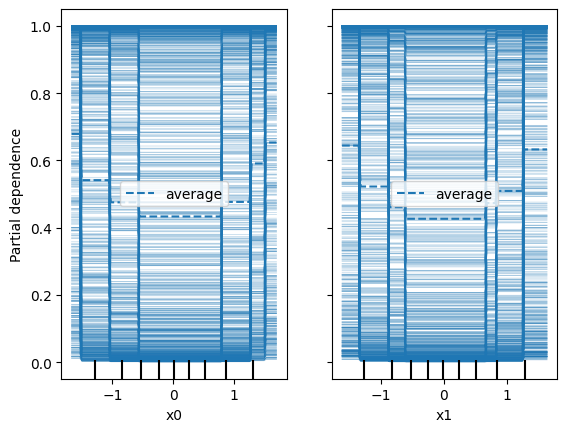

In [21]:
PartialDependenceDisplay.from_estimator(clf, x, features, kind='both')

<font color=red>Interpretation of Combined Partial Dependence and Individual Conditional Expectation (PDP & ICE) Plot (make_hastie_10_2 dataset):</font>
This plot combines both the Partial Dependence Plot (PDP) and Individual Conditional Expectation (ICE) curves for features 0 and 1 from the `make_hastie_10_2` dataset. The bold line represents the average effect (PDP) of the feature(s) on the predicted outcome, showing the general trend across all instances. The thinner lines, which are the ICE curves, show the individual prediction changes for each instance as the feature values vary. By viewing both together, we can observe the overall trend (PDP) while also identifying any significant variations or interactions at the individual instance level (ICE lines diverging from the PDP line), which helps in understanding model behavior and potential heterogeneity in predictions.
